# Tiered Results Analysis 

This notebook mirrors the multiple results analysis, but loads data from the separate tiered results files. 

In [20]:
%matplotlib inline

import os
import sys 
import json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [38]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [44]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
RESULTS  = {
    "howard single": os.path.join(FIXTURES, "howard-single-raft.json"),
    "howard floated": os.path.join(FIXTURES, "howard-floated-raft.json"),
    "bailis single": os.path.join(FIXTURES, "bailis-single-raft.json"),
    "bailis floated": os.path.join(FIXTURES, "bailis-floated-raft.json"),
}

def get_results_data(results=RESULTS):
    """
    Make this look like the multi-results structure. 
    """
    for name, path in results.items():
        with open(path, 'r') as f:
            data = json.load(f) 
            data['topology']['meta']['experiment'] = name 
            yield data 

            
data = list(get_results_data())


# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [51]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))
    conf  = list(rvals('settings'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        
        data['experiment'] = meta[idx]['experiment']
        data['variable (ms)'] = meta[idx]['variable']
        
        data['users'] = conf[idx]['users']
        data['anti-entropy delay (ms)'] = conf[idx]['anti_entropy_delay']
        data['rtype'] = meta[idx]['title'].split()[0].lower()
        for key, values in results.iteritems():
            
            if key == 'read latency':
                data['read latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)

            if key == 'write latency':
                data['write latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['visible writes'] = len(set([v[1] for v in values]))
            if key == 'commit latency':
                data['commit latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['committed writes'] = len(set([v[1] for v in values]))
            else:
                data[key] = len(values)
        
        data['ratio fully visible to writes'] = float(data['visible writes']) / float(data['write'])
        data['partial writes'] = data['write'] - data['visible writes'] 
        
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
df = df.fillna(0)

In [46]:
df

,anti-entropy delay (ms),commit latency (ms),committed writes,dropped write latency,dropped writes,eid,empty reads,experiment,ratio fully visible to writes,read,...,sent,stale reads,users,variable (ms),visibility latency,visibility latency (ms),visible writes,write,write latency,write latency (ms)
0,600,5159.509699,3346,10,10,e00,31,bailis single,0.994945,4695,...,19732,2775,3,N/A-N/Ams,3349,4411.690694,3346,3363,3353,1353.037101
1,600,3951.501062,3332,22,22,e01,35,howard single,0.991674,4695,...,57195,2240,3,N/A-N/Ams,3339,3323.818302,3335,3363,3339,1360.510877
2,2700,104.632371,3363,0,0,e02,5,howard floated,0.999108,4695,...,1334040,2,3,N/A-N/Ams,3360,2618.936891,3360,3363,10589,736.020293
3,10000,159.185220,3363,0,0,e03,5,bailis floated,0.997026,4695,...,370975,8,3,N/A-N/Ams,3353,6401.553819,3353,3363,11260,758.456027


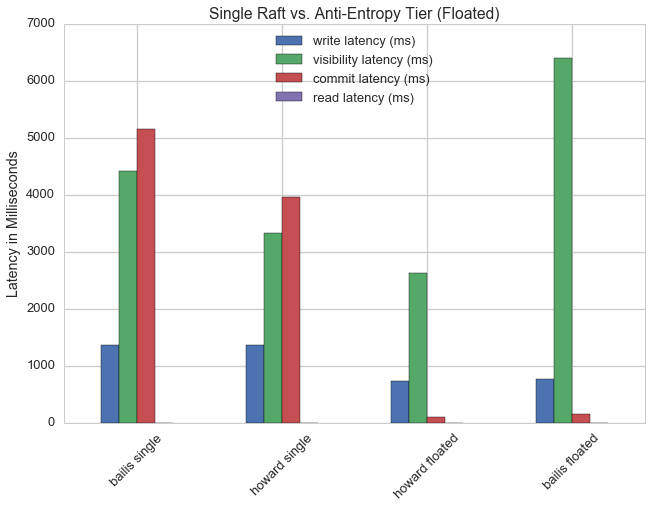

In [47]:
plt.figure(figsize=(14,14))
mpl.rcParams.update({'font.size': 22})

lat = pd.DataFrame(df, columns=['experiment', 'write latency (ms)', 'visibility latency (ms)', 'commit latency (ms)', 'read latency (ms)'])
axe = lat.plot(kind='bar', x='experiment', color=sns.color_palette())
axe.set_ylabel('Latency in Milliseconds')
axe.set_xlabel('')
axe.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
axe.set_title("Single Raft vs. Anti-Entropy Tier (Floated)")

for tick in axe.get_xticklabels():
    tick.set_rotation(45)

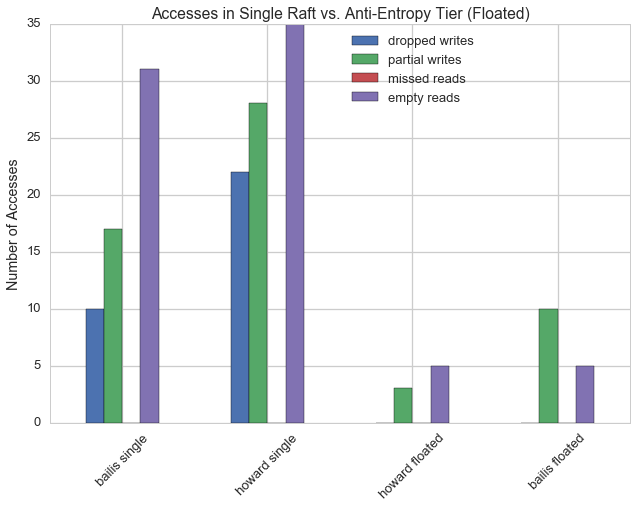

In [56]:
lat = pd.DataFrame(df, columns=['experiment', 'dropped writes', 'partial writes', 'missed reads', 'empty reads'])
axe = lat.plot(kind='bar', x='experiment', color=sns.color_palette())
axe.set_ylabel('Number of Accesses')
axe.set_xlabel('')
axe.legend(loc='best', bbox_to_anchor=(0.5, 1))
axe.set_title("Accesses in Single Raft vs. Anti-Entropy Tier (Floated)")

for tick in axe.get_xticklabels():
    tick.set_rotation(45)

In [70]:
# Create Message Traffic Data Frame 
columns = ['replica', 'timestamp', 'type', 'latency']

def messages():
    meta  = list(rvals('topology', 'meta'))
    for idx, result in enumerate(rvals('results')):
        timing, consensus = meta[idx]['experiment'].split()
        for key in ('sent', 'recv'):
            for message in result[key]:
                msg = dict(zip(columns, message))
                msg['timing'] = timing
                msg['consensus'] = consensus
                msg['experiment'] = meta[idx]['experiment']
                msg['recv'] = 1 if key == 'recv' else 0
                msg['sent'] = 1 if key == 'sent' else 0
                yield msg

def count(nums):
    return sum(nums)
            
msgs = pd.DataFrame(messages())

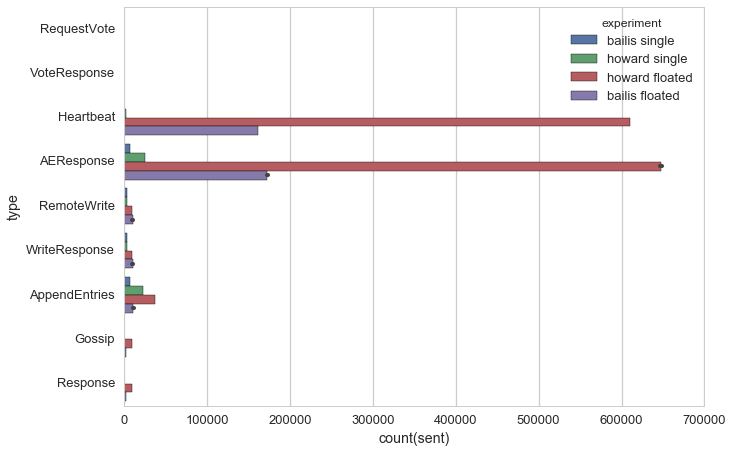

In [71]:
sns.barplot(y='type', x='sent', hue='experiment', data=msgs, estimator=count)